#### Libraries

In [1]:
library(dplyr)
library(lmtest)
library(car)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode



#### Data Loading and Merge

In [52]:
killings <- read.csv(file = 'num_killed_state.csv')
variables <- read.csv(file = 'sig_variables.csv')
population <- read.csv(file = 'state_pop.csv')

temp <- merge(killings, population, by="State")
data <- merge(variables, temp, by="State")
data$X.x <- NULL
data$X.y <- NULL
data$X <- NULL
data$state_abbrev <- NULL
data$X <- NULL
data$latitude <- NULL
data$longitude <- NULL
data$county_bucket <- factor(data$county_bucket)
data$nat_bucket <- factor(data$nat_bucket)
data$was.shot <- ifelse(data$was.shot == "Yes", 1, 0)
data <- tbl_df(data)
o_data <- data

In [53]:
head(data)

State,age,County,region,h_income,county_bucket,nat_bucket,urate,TotalPop,Black,⋯,Drive,Transit,PrivateWork,SelfEmployed,was.shot,is.black.binary,state.counts,black_pop,state_pop,perc.black
Alabama,55,Baldwin,South,48173,3,3,0.07307933,7455,13.6,⋯,89.5,0.0,79.4,2.4,1,0,8,1270051,4830620,26.29168
Alabama,17,Elmore,South,51367,3,3,0.09768638,3845,26.6,⋯,81.2,0.0,71.5,6.5,1,1,8,1270051,4830620,26.29168
Alabama,74,Jefferson,South,23977,1,1,0.14504881,3795,76.4,⋯,65.7,1.4,86.8,2.3,1,1,8,1270051,4830620,26.29168
Alabama,39,Jefferson,South,35780,2,2,0.05291894,3441,21.1,⋯,82.8,2.0,86.2,2.7,1,1,8,1270051,4830620,26.29168
Alabama,54,Jefferson,South,81996,5,5,0.03591606,4976,0.2,⋯,85.3,0.0,71.5,2.5,1,0,8,1270051,4830620,26.29168
Alabama,40,Lawrence,South,38078,3,2,0.16827934,5677,2.2,⋯,90.5,0.0,77.6,8.0,1,0,8,1270051,4830620,26.29168


#### Correcting Linear Dependency

In [54]:
data <- data %>% 
    select(-one_of("nonblack_perc", "black_pop"))

In [55]:
sapply(data,class)

State             age          County          region        h_income 
       "factor"       "integer"        "factor"        "factor"       "integer" 
  county_bucket      nat_bucket           urate        TotalPop           Black 
       "factor"        "factor"       "numeric"       "integer"       "numeric" 
        Poverty    ChildPoverty         Service    Construction           Drive 
      "numeric"       "numeric"       "numeric"       "numeric"       "numeric" 
        Transit     PrivateWork    SelfEmployed        was.shot is.black.binary 
      "numeric"       "numeric"       "numeric"       "numeric"       "integer" 
   state.counts       state_pop      perc.black 
      "integer"       "integer"       "numeric"

In [56]:
state_df <- tbl_df(data)
state_df <- state_df %>% 
    select(-c(County, region)) %>%
    group_by(State) %>%
    summarise_if(is.numeric, mean, na.rm = TRUE)
head(state_df)

State,age,h_income,urate,TotalPop,Black,Poverty,ChildPoverty,Service,Construction,Drive,Transit,PrivateWork,SelfEmployed,was.shot,is.black.binary,state.counts,state_pop,perc.black
Alabama,45.37500,46750.00,0.08934377,5013.375,22.037500,18.16250,23.50000,21.02500,9.82500,83.35000,0.662500,77.20000,5.050000,1.0000000,0.5000000,8,4830620,26.291679
Alaska,34.00000,46356.50,0.11290692,4363.000,13.400000,21.60000,36.00000,25.60000,8.05000,63.75000,2.550000,72.30000,7.650000,0.5000000,0.0000000,2,733375,3.237458
Arizona,36.16000,43081.68,0.12203292,4447.080,3.584000,23.05200,29.38000,23.79200,12.34000,74.13200,3.544000,76.33200,5.880000,1.0000000,0.0400000,25,6641928,3.976038
Arkansas,43.50000,38595.50,0.08996564,3573.000,26.925000,21.42500,31.82500,16.85000,10.52500,85.47500,0.325000,80.35000,4.375000,1.0000000,0.2500000,4,2958208,15.439997
California,36.27027,54808.27,0.12644515,5073.351,6.051351,21.22432,27.51351,21.48108,12.14054,68.04189,7.044595,80.38108,7.497297,0.9189189,0.1891892,74,38421464,5.623900
Colorado,36.50000,50118.33,0.10240263,4261.833,6.791667,18.55833,21.60833,21.33333,13.16667,72.10833,4.116667,77.21667,7.050000,1.0000000,0.3333333,12,5278906,3.849205


In [57]:
dim(state_df)

[1] 47 19

### Aggregate continuous variables from full ACS

In [58]:
full.acs <- read.csv("acs2015_census_tract_data.csv")

In [59]:
head(full.acs)

CensusTract,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,⋯,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
1001020100,Alabama,Autauga,1948,940,1008,0.9,87.4,7.7,0.3,⋯,0.5,2.3,2.1,25.0,943,77.1,18.3,4.6,0,5.4
1001020200,Alabama,Autauga,2156,1059,1097,0.8,40.4,53.3,0.0,⋯,0.0,0.7,0.0,23.4,753,77.0,16.9,6.1,0,13.3
1001020300,Alabama,Autauga,2968,1364,1604,0.0,74.5,18.6,0.5,⋯,0.0,0.0,2.5,19.6,1373,64.1,23.6,12.3,0,6.2
1001020400,Alabama,Autauga,4423,2172,2251,10.5,82.8,3.7,1.6,⋯,0.0,2.6,1.6,25.3,1782,75.7,21.2,3.1,0,10.8
1001020500,Alabama,Autauga,10763,4922,5841,0.7,68.5,24.8,0.0,⋯,0.0,0.6,0.9,24.8,5037,67.1,27.6,5.3,0,4.2
1001020600,Alabama,Autauga,3851,1787,2064,13.1,72.9,11.9,0.0,⋯,0.0,6.0,4.5,19.8,1560,79.4,14.7,5.8,0,10.9


In [60]:
# Add number number of poor, child poor, service, construction, drive, transit, private, self employed, 
# and unemployed
full.acs <- full.acs %>%
    mutate(num_poverty = Poverty * TotalPop * 0.01) %>%
    mutate(num_child_poverty = ChildPoverty * TotalPop * 0.01) %>%
    mutate(num_service = Service * TotalPop * 0.01) %>%
    mutate(num_construction = Construction * TotalPop * 0.01) %>%
    mutate(num_drive = Drive * TotalPop * 0.01) %>%
    mutate(num_transit = Transit * TotalPop * 0.01) %>%
    mutate(num_private = PrivateWork * TotalPop * 0.01) %>%
    mutate(num_self_employed = SelfEmployed * TotalPop * 0.01) %>%
    mutate(num_unemployed = Unemployment * TotalPop * 0.01)

In [61]:
# Only select continuous variables we want and state
state_vars <- full.acs %>%
    select(c(State, num_poverty, num_child_poverty, num_service, num_construction, num_drive, num_transit,
            num_private, num_self_employed, num_unemployed)) %>%
    group_by(State) %>%
    summarize_all(funs(sum), na.rm = TRUE)

In [62]:
# Merge state_vars with population
merged_var_pop <- left_join(state_vars, population, by='State')

In [63]:
# Create state-level percentages
merged_var_pop <- merged_var_pop %>%
    mutate()

In [64]:
# Merge
new_state_df <- state_df %>%
    select(c(State, age, was.shot, is.black.binary, state.counts, state_pop, perc.black))
merged_df <- left_join(new_state_df, state_vars, by='State')

Warning message:
“Column `State` joining factors with different levels, coercing to character vector”

In [65]:
head(merged_df)

State,age,was.shot,is.black.binary,state.counts,state_pop,perc.black,num_poverty,num_child_poverty,num_service,num_construction,num_drive,num_transit,num_private,num_self_employed,num_unemployed
Alabama,45.37500,1.0000000,0.5000000,8,4830620,26.291679,919744.22,1301940.51,833125.0,488663.73,4109044.8,23371.98,3776445.9,254272.51,467458.83
Alaska,34.00000,0.5000000,0.0000000,2,733375,3.237458,74725.44,98918.77,130710.9,93220.63,488217.1,11706.61,490752.1,45623.46,63286.55
Arizona,36.16000,1.0000000,0.0400000,25,6641928,3.976038,1222867.36,1602398.78,1362564.2,647676.43,5050143.2,136399.82,5205311.6,403437.75,619755.99
Arkansas,43.50000,1.0000000,0.2500000,4,2958208,15.439997,576526.28,802528.03,517308.6,323823.88,2433445.6,13740.96,2276173.7,188636.71,234620.97
California,36.27027,0.9189189,0.1891892,74,38421464,5.623900,6272614.15,7873067.87,7358486.3,3755424.88,28208342.3,1897598.36,29731239.5,3147127.28,3898336.96
Colorado,36.50000,1.0000000,0.3333333,12,5278906,3.849205,676553.48,866195.55,938692.9,511916.69,3976199.1,163197.78,4167491.3,336822.69,374119.54


In [66]:
# Create new state-level percentages
merged_df <- merged_df %>%
    mutate(Poverty = (num_poverty/state_pop) * 100) %>%
    mutate(ChildPoverty = (num_child_poverty/state_pop) * 100) %>%
    mutate(Service = (num_service/state_pop) * 100) %>%
    mutate(Construction = (num_construction/state_pop) * 100) %>%
    mutate(Drive = (num_drive/state_pop) * 100) %>%
    mutate(Transit = (num_transit/state_pop) * 100) %>%
    mutate(Private = (num_private/state_pop) * 100) %>%
    mutate(SelfEmployment = (num_self_employed/state_pop) * 100) %>%
    mutate(Unemployment = (num_unemployed/state_pop) * 100)

In [71]:
# Remove non percentage columns
merged_df <- merged_df %>%
    select(-c(num_poverty, num_child_poverty, num_service, num_construction, num_drive, num_transit,
             num_private, num_self_employed, num_unemployed))

In [80]:
# Get Income for each state
acs_income <- full.acs %>%
    group_by(State) %>%
    summarize(state_income = mean(Income, na.rm = TRUE))

In [81]:
# Merge merged_df and acs_income
new_merged_df <- left_join(merged_df, acs_income, by='State')

Warning message:
“Column `State` joining character vector and factor, coercing into character vector”

In [82]:
head(new_merged_df)

State,age,was.shot,is.black.binary,state.counts,state_pop,perc.black,Poverty,ChildPoverty,Service,Construction,Drive,Transit,Private,SelfEmployment,Unemployment,state_income
Alabama,45.37500,1.0000000,0.5000000,8,4830620,26.291679,19.03988,26.95183,17.24675,10.115963,85.06247,0.4838298,78.17725,5.263766,9.676994,43296.36
Alaska,34.00000,0.5000000,0.0000000,2,733375,3.237458,10.18925,13.48816,17.82320,12.711182,66.57127,1.5962648,66.91694,6.221027,8.629494,70354.74
Arizona,36.16000,1.0000000,0.0400000,25,6641928,3.976038,18.41133,24.12551,20.51459,9.751332,76.03430,2.0536178,78.37049,6.074106,9.330965,54207.82
Arkansas,43.50000,1.0000000,0.2500000,4,2958208,15.439997,19.48904,27.12886,17.48723,10.946623,82.26080,0.4645027,76.94434,6.376722,7.931186,41935.63
California,36.27027,0.9189189,0.1891892,74,38421464,5.623900,16.32581,20.49133,19.15202,9.774289,73.41819,4.9389018,77.38185,8.191065,10.146248,67264.78
Colorado,36.50000,1.0000000,0.3333333,12,5278906,3.849205,12.81617,16.40862,17.78196,9.697401,75.32241,3.0915076,78.94612,6.380540,7.087066,64657.80


#### Model 1: Predicting Killed Per State

In [83]:
glm1 <- glm(state.counts ~.-State-is.black.binary, data=new_merged_df, family="poisson")
summary(glm1)


Call:
glm(formula = state.counts ~ . - State - is.black.binary, family = "poisson", 
    data = new_merged_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2257  -1.0007  -0.3298   0.5225   4.3383  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -2.610e+00  4.527e+00  -0.577 0.564237    
age            -4.225e-02  1.345e-02  -3.141 0.001686 ** 
was.shot       -2.181e-01  3.807e-01  -0.573 0.566676    
state_pop       5.742e-08  9.471e-09   6.062 1.34e-09 ***
perc.black     -9.976e-03  8.855e-03  -1.127 0.259901    
Poverty        -2.024e-01  1.524e-01  -1.328 0.184215    
ChildPoverty    3.315e-01  1.142e-01   2.903 0.003698 ** 
Service        -1.304e-02  3.828e-02  -0.341 0.733425    
Construction    1.500e-03  6.984e-02   0.021 0.982869    
Drive          -4.270e-02  3.278e-02  -1.302 0.192746    
Transit        -5.487e-02  3.952e-02  -1.388 0.165003    
Private         5.315e-02  3.082e-02   1.724 0.084631 .  
SelfE

In [84]:
# Before we add back in is.black.binary look at variation inflation factors to detect collinearity
vif(glm1)

age       was.shot      state_pop     perc.black        Poverty 
      1.608264       1.665157       6.872592       2.857127      76.811875 
  ChildPoverty        Service   Construction          Drive        Transit 
     98.738191       1.693348       5.776751      21.114585      20.506962 
       Private SelfEmployment   Unemployment   state_income 
      4.353196       5.054617       3.547551      12.013817

In [88]:
# Remove Income, ChildPoverty, Transit
glm1a <- glm(state.counts ~.-State-is.black.binary-ChildPoverty-Transit-state_income,
             data=new_merged_df, family="poisson")
summary(glm1a)


Call:
glm(formula = state.counts ~ . - State - is.black.binary - ChildPoverty - 
    Transit - state_income, family = "poisson", data = new_merged_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2706  -1.0335  -0.4404   0.3939   4.0867  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     2.144e+00  2.197e+00   0.976  0.32920    
age            -3.164e-02  1.113e-02  -2.843  0.00447 ** 
was.shot       -5.731e-01  3.596e-01  -1.594  0.11103    
state_pop       8.047e-08  6.420e-09  12.534  < 2e-16 ***
perc.black     -4.831e-03  7.795e-03  -0.620  0.53544    
Poverty         9.556e-02  3.091e-02   3.092  0.00199 ** 
Service         7.363e-03  3.764e-02   0.196  0.84489    
Construction    5.822e-03  5.867e-02   0.099  0.92095    
Drive           1.424e-02  1.143e-02   1.246  0.21267    
Private        -6.043e-03  2.589e-02  -0.233  0.81543    
SelfEmployment -9.135e-02  7.633e-02  -1.197  0.23138    
Unemployment   -7.397e-

In [89]:
# Check variation inflation factors agaon
vif(glm1a)

age       was.shot      state_pop     perc.black        Poverty 
      1.206434       1.426933       3.254839       2.284426       3.071812 
       Service   Construction          Drive        Private SelfEmployment 
      1.591294       4.262468       2.833084       3.066614       3.859991 
  Unemployment 
      3.158554

In [91]:
# Now add back in is.black.binary
glm2 <- glm(state.counts ~.-State-ChildPoverty-state_income-Transit,
             data=new_merged_df, family="poisson")
summary(glm2)


Call:
glm(formula = state.counts ~ . - State - ChildPoverty - state_income - 
    Transit, family = "poisson", data = new_merged_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9037  -1.0089  -0.3420   0.4786   4.4702  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -6.901e-01  2.344e+00  -0.294 0.768479    
age             -2.734e-02  1.143e-02  -2.392 0.016769 *  
was.shot        -7.691e-01  3.852e-01  -1.997 0.045841 *  
is.black.binary  1.454e+00  4.333e-01   3.357 0.000789 ***
state_pop        7.240e-08  6.838e-09  10.589  < 2e-16 ***
perc.black      -2.533e-02  9.966e-03  -2.542 0.011025 *  
Poverty          1.015e-01  3.121e-02   3.252 0.001147 ** 
Service          3.726e-03  3.905e-02   0.095 0.923991    
Construction     8.337e-02  6.226e-02   1.339 0.180564    
Drive            1.262e-02  1.129e-02   1.117 0.263826    
Private          9.448e-03  2.565e-02   0.368 0.712588    
SelfEmployment  -3.306e-02  7

In [92]:
lrtest(glm1a, glm2)

#Df,LogLik,Df,Chisq,Pr(>Chisq)
12,-130.6540,NA,NA,NA
13,-124.5685,1,12.17102,0.0004853783


#### Model 2: Predicting If Shot

In [97]:
shot_df <- tbl_df(data)
shot_df <- shot_df %>% 
    select(-c(State, County, region))
head(shot_df)

age,h_income,county_bucket,nat_bucket,urate,TotalPop,Black,Poverty,ChildPoverty,Service,Construction,Drive,Transit,PrivateWork,SelfEmployed,was.shot,is.black.binary,state.counts,state_pop,perc.black
55,48173,3,3,0.07307933,7455,13.6,6.5,7.0,15.5,10.2,89.5,0.0,79.4,2.4,1,0,8,4830620,26.29168
17,51367,3,3,0.09768638,3845,26.6,16.2,27.1,22.5,11.2,81.2,0.0,71.5,6.5,1,1,8,4830620,26.29168
74,23977,1,1,0.14504881,3795,76.4,42.6,60.4,32.4,7.0,65.7,1.4,86.8,2.3,1,1,8,4830620,26.29168
39,35780,2,2,0.05291894,3441,21.1,22.9,23.3,31.5,8.5,82.8,2.0,86.2,2.7,1,1,8,4830620,26.29168
54,81996,5,5,0.03591606,4976,0.2,0.9,0.5,10.5,6.8,85.3,0.0,71.5,2.5,1,0,8,4830620,26.29168
40,38078,3,2,0.16827934,5677,2.2,22.2,20.3,19.5,16.3,90.5,0.0,77.6,8.0,1,0,8,4830620,26.29168


In [98]:
glm3 = glm(was.shot ~.-is.black.binary, data=shot_df, family="binomial")
summary(glm3)


Call:
glm(formula = was.shot ~ . - is.black.binary, family = "binomial", 
    data = shot_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6134   0.2892   0.4018   0.5405   1.2082  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)  
(Intercept)     3.171e+00  2.859e+00   1.109   0.2673  
age            -2.121e-02  1.112e-02  -1.907   0.0565 .
h_income       -3.948e-05  2.357e-05  -1.675   0.0940 .
county_bucket2  1.212e-01  4.464e-01   0.272   0.7860  
county_bucket3 -1.475e-01  5.390e-01  -0.274   0.7843  
county_bucket4 -3.998e-01  6.357e-01  -0.629   0.5294  
county_bucket5 -6.211e-02  7.530e-01  -0.082   0.9343  
nat_bucket2     1.339e+00  5.458e-01   2.453   0.0142 *
nat_bucket3     1.754e+00  7.220e-01   2.429   0.0151 *
nat_bucket4     2.013e+00  9.560e-01   2.105   0.0353 *
nat_bucket5     3.607e+00  1.805e+00   1.998   0.0457 *
urate          -4.776e+00  2.831e+00  -1.687   0.0916 .
TotalPop        9.197e-05  8.366e-05   1.099   0

In [99]:
vif(glm3)

,GVIF,Df,GVIF^(1/(2*Df))
age,1.098116,1,1.047910
h_income,12.969477,1,3.601316
county_bucket,3.450435,4,1.167439
nat_bucket,21.156805,4,1.464473
urate,2.341512,1,1.530200
TotalPop,1.213841,1,1.101744
Black,2.632346,1,1.622451
Poverty,13.924594,1,3.731567
ChildPoverty,8.655399,1,2.942006
Service,2.227826,1,1.492590


In [101]:
glm4 = glm(was.shot ~.-is.black.binary-h_income-nat_bucket-ChildPoverty, data=shot_df, family="binomial")
summary(glm4)


Call:
glm(formula = was.shot ~ . - is.black.binary - h_income - nat_bucket - 
    ChildPoverty, family = "binomial", data = shot_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5231   0.3271   0.4330   0.5417   1.2028  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)  
(Intercept)     3.270e+00  2.449e+00   1.335   0.1818  
age            -2.039e-02  1.086e-02  -1.877   0.0606 .
county_bucket2  2.852e-01  4.300e-01   0.663   0.5071  
county_bucket3  6.439e-02  4.870e-01   0.132   0.8948  
county_bucket4 -2.749e-01  5.539e-01  -0.496   0.6197  
county_bucket5 -9.081e-03  6.059e-01  -0.015   0.9880  
urate          -3.170e+00  2.646e+00  -1.198   0.2309  
TotalPop        1.048e-04  8.114e-05   1.291   0.1967  
Black           4.521e-03  8.584e-03   0.527   0.5984  
Poverty         1.836e-02  1.710e-02   1.074   0.2828  
Service        -3.931e-02  2.225e-02  -1.767   0.0773 .
Construction    2.831e-03  2.556e-02   0.111   0.9118  
Drive    

In [102]:
vif(glm4)

,GVIF,Df,GVIF^(1/(2*Df))
age,1.070312,1,1.034559
county_bucket,1.934011,4,1.085944
urate,2.102979,1,1.450165
TotalPop,1.194227,1,1.092807
Black,2.646700,1,1.626868
Poverty,2.789029,1,1.670039
Service,2.033559,1,1.426029
Construction,1.337060,1,1.156313
Drive,4.502511,1,2.121912
Transit,4.544445,1,2.131770


In [103]:
glm5 = glm(was.shot ~.-h_income-nat_bucket-ChildPoverty, data=shot_df, family="binomial")
summary(glm5)


Call:
glm(formula = was.shot ~ . - h_income - nat_bucket - ChildPoverty, 
    family = "binomial", data = shot_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5612   0.2867   0.3966   0.5411   1.4690  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)   
(Intercept)      3.640e+00  2.427e+00   1.500  0.13368   
age             -2.700e-02  1.140e-02  -2.369  0.01784 * 
county_bucket2   3.246e-01  4.337e-01   0.749  0.45415   
county_bucket3   6.983e-02  4.926e-01   0.142  0.88728   
county_bucket4  -1.446e-01  5.609e-01  -0.258  0.79652   
county_bucket5   3.054e-02  6.121e-01   0.050  0.96021   
urate           -3.241e+00  2.712e+00  -1.195  0.23213   
TotalPop         9.266e-05  8.187e-05   1.132  0.25772   
Black            1.398e-02  9.352e-03   1.495  0.13502   
Poverty          1.982e-02  1.696e-02   1.169  0.24246   
Service         -4.339e-02  2.265e-02  -1.916  0.05541 . 
Construction     5.216e-03  2.578e-02   0.202  0.83967   
D

Area under the curve: 0.679

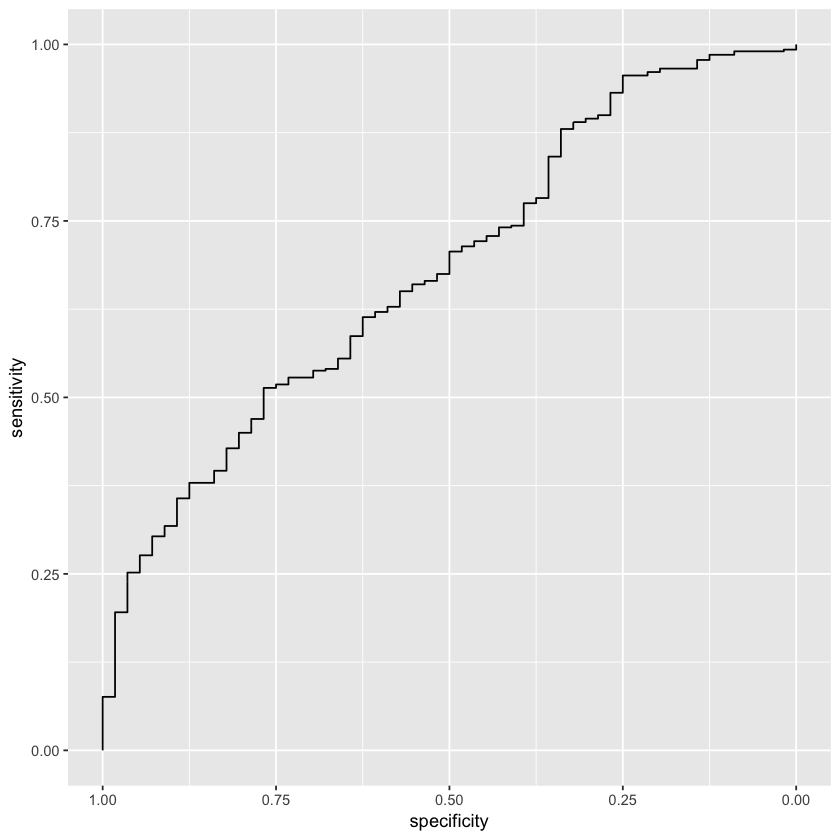

In [106]:
attach(shot_df)
glm.probs = predict(glm4, type="response")
glm.odds = exp(predict(glm4, type="link"))

roc.2 = roc(was.shot,glm.probs)
auc(roc.2)
ggroc(data=roc.2)
detach(shot_df)

In [105]:
lrtest(glm4, glm5)

#Df,LogLik,Df,Chisq,Pr(>Chisq)
19,-159.0896,NA,NA,NA
20,-155.1112,1,7.956775,0.00479077


Area under the curve: 0.7219

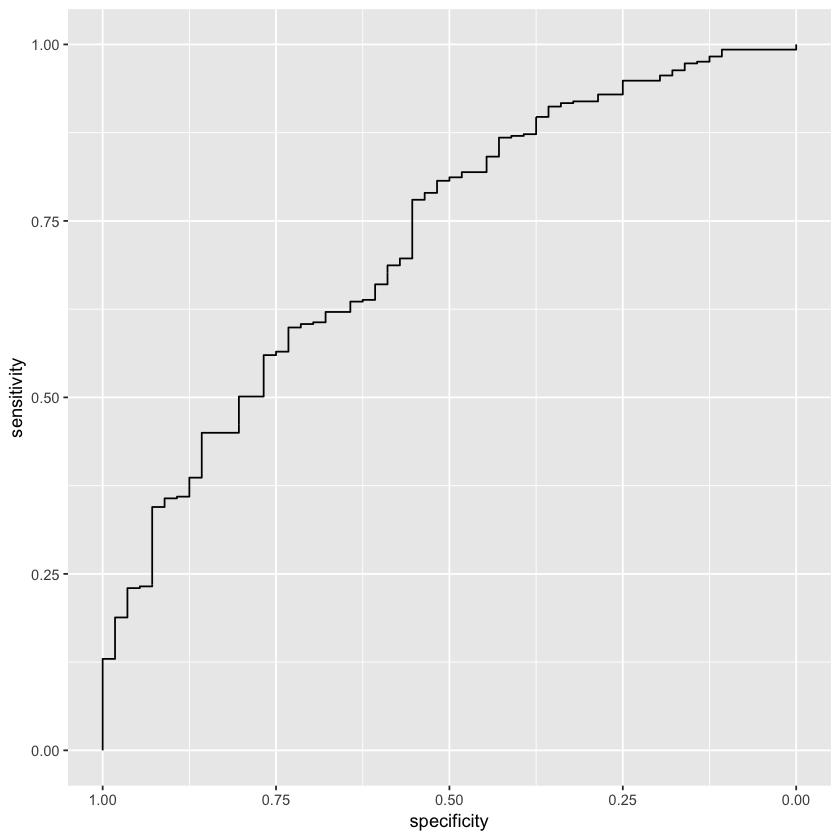

In [107]:
attach(shot_df)
glm.probs = predict(glm5, type="response")
glm.odds = exp(predict(glm5, type="link"))

roc.2 = roc(was.shot,glm.probs)
auc(roc.2)
ggroc(data=roc.2)
detach(shot_df)

#### Model 3: Predict a killed person being African American in a certain region (compare to african americans in that region)

In [100]:
killed_df <- tbl_df(data)
killed_df <- killed_df %>% 
    select(-c(State, County))
head(killed_df)

age,region,h_income,county_bucket,nat_bucket,urate,TotalPop,Black,Poverty,ChildPoverty,⋯,Construction,Drive,Transit,PrivateWork,SelfEmployed,was.shot,is.black.binary,state.counts,state_pop,perc.black
55,South,48173,3,3,0.07307933,7455,13.6,6.5,7.0,⋯,10.2,89.5,0.0,79.4,2.4,1,0,8,4830620,26.29168
17,South,51367,3,3,0.09768638,3845,26.6,16.2,27.1,⋯,11.2,81.2,0.0,71.5,6.5,1,1,8,4830620,26.29168
74,South,23977,1,1,0.14504881,3795,76.4,42.6,60.4,⋯,7.0,65.7,1.4,86.8,2.3,1,1,8,4830620,26.29168
39,South,35780,2,2,0.05291894,3441,21.1,22.9,23.3,⋯,8.5,82.8,2.0,86.2,2.7,1,1,8,4830620,26.29168
54,South,81996,5,5,0.03591606,4976,0.2,0.9,0.5,⋯,6.8,85.3,0.0,71.5,2.5,1,0,8,4830620,26.29168
40,South,38078,3,2,0.16827934,5677,2.2,22.2,20.3,⋯,16.3,90.5,0.0,77.6,8.0,1,0,8,4830620,26.29168


In [101]:
glm5 = glm(is.black.binary ~.-region, data=killed_df, family="binomial")
summary(glm5)


Call:
glm(formula = is.black.binary ~ . - region, family = "binomial", 
    data = killed_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6637  -0.6218  -0.3773   0.2573   2.5707  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -5.103e+00  2.527e+00  -2.020 0.043423 *  
age            -4.391e-02  1.169e-02  -3.754 0.000174 ***
h_income        3.294e-05  2.285e-05   1.442 0.149436    
county_bucket2 -6.932e-02  3.822e-01  -0.181 0.856089    
county_bucket3 -8.696e-01  4.757e-01  -1.828 0.067526 .  
county_bucket4 -3.784e-01  5.775e-01  -0.655 0.512238    
county_bucket5 -1.746e+00  6.904e-01  -2.529 0.011426 *  
nat_bucket2     3.695e-01  4.913e-01   0.752 0.451997    
nat_bucket3     1.074e+00  6.501e-01   1.652 0.098579 .  
nat_bucket4     1.408e+00  8.751e-01   1.609 0.107533    
nat_bucket5     1.187e+00  1.485e+00   0.799 0.424018    
urate           5.558e-02  2.691e+00   0.021 0.983520    
TotalPop       -1.389e

In [102]:
glm5.probs <- predict(glm5, type="response")
glm5.odds <- exp(predict(glm5,type="link"))
glm5.pred <- (glm5.probs > 0.5)
table(glm5.pred, killed_df$is.black.binary)

         
glm5.pred   0   1
    FALSE 312  60
    TRUE   20  73

In [125]:
comp_df <- data.frame(data$region,glm5.pred)
comp_df <- comp_df %>%
    group_by(data.region) %>%
    summarise(percent = mean(glm5.pred,na.rm=TRUE))
comp_df

data.region,percent
Midwest,0.27777778
Northeast,0.30769231
South,0.27777778
West,0.03846154


In [158]:
o_data <- tbl_df(o_data <- o_data)
o_data <- o_data %>% 
    select(-c(County, State)) %>%
    group_by(region) %>%
    summarise(blacks = sum(as.numeric(black_pop),na.rm=TRUE),
              total = sum(as.numeric(state_pop),na.rm=TRUE))
o_data$percent <- o_data$blacks/o_data$total
head(o_data)

region,blacks,total,percent
Midwest,61744210,543890718,0.11352319
Northeast,61247420,482931171,0.12682433
South,394240731,2527551225,0.15597735
West,173395715,3230437975,0.05367561


In [162]:
final_df <- data.frame(o_data$region, comp_df$percent, o_data$percent)
final_df

o_data.region,comp_df.percent,o_data.percent
Midwest,0.27777778,0.11352319
Northeast,0.30769231,0.12682433
South,0.27777778,0.15597735
West,0.03846154,0.05367561
